<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-текстов" data-toc-modified-id="Лемматизация-текстов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Лемматизация текстов</a></span></li><li><span><a href="#Разделение-выборок,-преобразование-текстов" data-toc-modified-id="Разделение-выборок,-преобразование-текстов-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Разделение выборок, преобразование текстов</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Обучение</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
from langdetect import detect
from tqdm import notebook
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
import spacy as sp
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Olli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data = pd.read_csv('toxic_comments.csv')

In [5]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Датасет состоит из двух колонок - text - комментарий, toxic - оценка токсичности комментраия - да - 1, нет - 0.   
В текстах имеются разные символы и разные регистры.

In [6]:
data['text'] = data['text'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Определим на каком языке наши тексты

In [7]:
detect(data['text'][500])

'en'

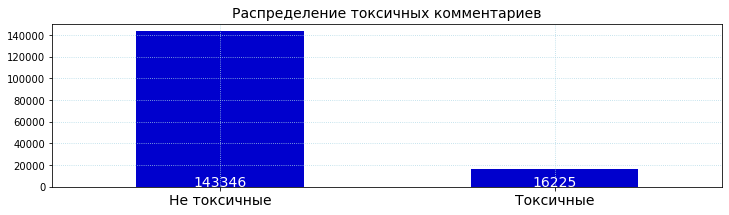

In [8]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=14, color='w')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=14, color='w')
plt.show()

Токсичных комментариев намного меньше, чем не токсичных.

In [9]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


Дубликатов не обнаружено, но тексты в разных регистрах и с разным количеством дополнительных символов. Поэтому выполним обработку строк и далее проверим дубликаты.

Удалим все символы в текстах за исключением буквенных и приведем тексты к нижнему регистру.

In [10]:
def clear_text(text):
    
    clear = re.sub(r'[^a-zA-Z]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[a-zA-Z]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join(clear.split())

In [11]:
data['text'] = data['text'].apply(clear_text)

In [12]:
data['text'] = data['text'].str.lower()

In [13]:
data.tail()

,text,toxic
159566,and for the second time of asking when your vi...,0
159567,you should be ashamed of yourself that is horr...,0
159568,spitzer umm theres no actual article for prost...,0
159569,and it looks like it was actually you who put ...,0
159570,and really don think you understand came here ...,0


In [14]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 1332


После обработки появилось 1332 дубликатов. Так как уникальной информации такие тексты не несут, удалим их.

In [15]:
data = data.drop_duplicates()

In [16]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158239 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    158239 non-null  object
 1   toxic   158239 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


**Вывод**
***
Тексты предобработаны:
- удалено дубликаов 1332 
- текст приведен к нижнему регистру и удалены все символы, кроме буквенных, а так же, лишние пробелы и единичные буквы.

Всего в датасете изначально было 159571, после обработки стало 158239 строк.   
Датасет состоит из двух столбцов - текста комментария на английском языке и оценки токсичности комментария.  
Целевой признак - toxic - категориальный - не токссичный комментарий - 0, токсичный - 1.  
Пропущенных значений нет.  
Не токсичных комментариев - 143346, токсичных - 16225, количество не токсичных комментариев много выше.

## Обучение

### Лемматизация текстов

Проведем лемматизацию тектов датасета с помощью spacy.

In [18]:
nlp = sp.load("en_core_web_sm")

In [19]:
def lemme_text(text):
    
    doc = nlp(text)
    
    return ' '.join([token.lemma_ for token in doc])

In [20]:
%%time
data['text'] = data['text'].apply(lemme_text)

Wall time: 25min 36s


In [21]:
data.head(10)

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour m seemin...,0
2,hey man m really not try to edit war it just t...,0
3,more can make any real suggestion on improveme...,0
4,you sir be my hero any chance you remember wha...,0
5,congratulation from I as well use the tool wel...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense be offensive to you...,0
9,alignment on this subject and which be contrar...,0


**Вывод**
***
Проведена лемматизация текстов датасета для дальнейшей обработки.

### Разделение выборок, преобразование текстов

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['toxic'], test_size=.2, random_state=5)

In [23]:
def Xy_shape(Xtrain, Xtest, ytrain=y_train, ytest=y_test):
    print('Размер тренировочной выборки', Xtrain.shape)
    print('Размер тренировочной выборки - целевого признака', ytrain.shape)
    print('Размер тестовой выборки', Xtest.shape)
    print('Размер тестовой выборки - целевого признака', ytest.shape)

In [24]:
Xy_shape(X_train, X_test)

Размер тренировочной выборки (126591,)
Размер тренировочной выборки - целевого признака (126591,)
Размер тестовой выборки (31648,)
Размер тестовой выборки - целевого признака (31648,)


In [25]:
X_train.head()

143295    no it do not the world third old airline refer...
31139     what be you talk about why would add pornograp...
117557    cush in universe be pov you may refard the bib...
85323     yep the wp software should not allow reversion...
38696     clarify this as unusually large for portrait b...
Name: text, dtype: object

In [26]:
ones = y_test.sum()

In [27]:
y_train.value_counts()

0    113808
1     12783
Name: toxic, dtype: int64

In [28]:
y_test.value_counts()

0    28329
1     3319
Name: toxic, dtype: int64

Создадим TfidfVectorizer, при этом:  
- удалим английские стоп-слова; 
- ограничим количество признаков 15000;  
- укажем минимальное количество встречаемости слов - 5, ограничим встречаемость слов выше 70 %.  

Так же, составим вектос с помощью нграмм count_ngram.  

Далее модели будут использованы для обучения.

In [29]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'), 
                               strip_accents='unicode', 
                               max_features=15000, 
                               min_df=5,
                               max_df=.7
                              )

count_ngram = TfidfVectorizer(stop_words=stopwords.words('english'), 
                              strip_accents='unicode',
                              max_features=15000,
                              min_df=5,
                              max_df=.7,
                              ngram_range=(1, 2),
                              binary=True
                              )

**Вывод**
***
Тренировочная и тестовая выборки разделены в отношении 80% и 20%.   

Созданы необученные TfidfVectorizer  c максимальным количеством признаков - 15000, с единичными словами и нграммами.  

### Обучение

Обучим модели как на векторах из слов, так и из нграм.
Создадим списки для далнейшео анализа работы всех моделей.  
Для обучения и наглядного представления результатов создадим несолько функций:  
- heatmap_confusion_matrix - матрица ошибок модели
- wordplot - нагядное представелние текстов(слов) - выделим топ негативных и позитивных слов
- rndm_pipe_with_test - поик параметров и обучение моделей с помощью Pipeline и RandomizedSearchCV, вычисление метрики f1, а так же, тестирование модели с помощью лучшего оценщика.  

Обучим модели: 
- LogisticRegression
- LinearSVC  
- LGBMClassifier  

In [30]:
best_est, score, score_test = [], [], []
model_name = ['LogisticRegression', 'LogisticRegression_ngramm', 
              'LinearSVC', 'LinearSVC_ngramm',
              'LGBMClassifier', 'LGBMClassifier_ngramm']

In [31]:
# функция для построения тепловой карты по матрице ошибок модели
def heatmap_confusion_matrix(best_predictions, target=y_train, name='Матрица ошибок модели'):

    heatmap_1 = sns.heatmap((confusion_matrix(target, best_predictions)), 
                            cmap="YlGnBu", 
                            annot=True, fmt='d')
    
    heatmap_1.set_title(name, fontdict={'fontsize':14})
    heatmap_1.set_xlabel('Предсказания', fontsize=14)
    heatmap_1.set_ylabel('Ответы', fontsize=14)
    
    return heatmap_1

In [32]:
def wordplot(txt1, txt2):
    
    text=' '.join(txt1)
    text1=' '.join(txt2)

    fig, axs = plt.subplots(figsize=(15, 10))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    
    wordcloud = WordCloud(width=480, height=480, background_color="skyblue").generate(text)
    plt.axis('off')

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('negative_words', fontsize=16)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=480, height=480, background_color="pink").generate(text1)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('positive_words', fontsize=16)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [33]:
def rndm_pipe_with_test(model, params, 
                        tfidf=count_tf_idf, 
                        features=X_train, target=y_train, 
                        feature_test=X_test, target_test=y_test):
    
    # пайплайн + шаги (TfidfVectorizer, модель)
    steps = [('tfidf', tfidf), ('model', model)]
    pipe = Pipeline(steps)
    
    # поиск параметров + лучшая модель и результат f1
    RSCV = RandomizedSearchCV(estimator=pipe, param_distributions=params, 
                              cv=10, n_jobs=-1, scoring='f1', random_state=5)

    RSCV.fit(features, target)

    best_estimator = RSCV.best_estimator_
    best_score = RSCV.best_score_
   

    # тестирование     
    pred_test = best_estimator.predict(feature_test)
    test_result = f1_score(y_test, pred_test, zero_division=0)
    
    
    # все результаты, в том числе модель 
    print('Модель с лучшими гиперпараметрами:')
    print(best_estimator)
    print()
    print(f'F1 на тренировочной выборке {best_score:.3f}'.format())
    print()
    print(f'F1 на тестовой выборке {test_result:.3f}'.format())
    
    
    # добавление в список результатов 
    best_est.append(best_estimator)
    score.append(best_score)
    score_test.append(test_result)
    
    # heatmap матрицы ошибок на тесте
    heatmap_confusion_matrix(pred_test, target_test, name='Матрица ошибок модели')
    
    return best_estimator, best_score

**LogisticRegression**

In [34]:
lg_params = {
    'model__C': [.1, 1, 2, 3, 5, 10, 12],
    'model__class_weight': ['balanced', None],
    'model__max_iter': [1000, 2000, 3000],
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
}

C:\Users\Olli\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.74305521 0.54944067 0.65982062 0.74101052
 0.65246749 0.65246749        nan        nan]
  warnings.warn(


Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=15000, min_df=5,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model',
                 LogisticRegression(C=3, class_weight='balanced', max_iter=3000,
                                    n_jobs=-1, random_state=5))])

F1 на трен

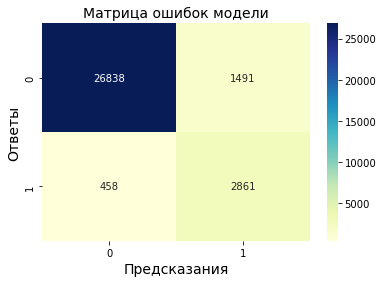

In [35]:
%%time
lg1, lg1_f1 = rndm_pipe_with_test(model=LogisticRegression(random_state=5, n_jobs=-1), 
                                  params=lg_params, 
                                  tfidf=count_tf_idf)

C:\Users\Olli\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.73391806 0.53923253 0.61916331 0.73507579
 0.6144666  0.6144666         nan        nan]
  warnings.warn(


Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, max_df=0.7, max_features=15000,
                                 min_df=5, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=1000,
           

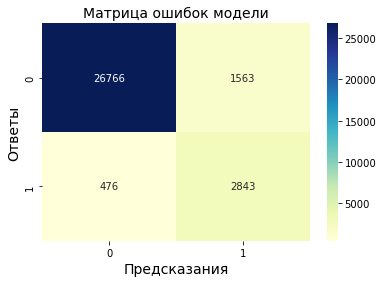

In [36]:
%%time
lg2, lg2_f1 = rndm_pipe_with_test(model=LogisticRegression(random_state=5, n_jobs=-1), 
                                  params=lg_params, 
                                  tfidf=count_ngram)

**LinearSVC**

In [37]:
svc_params = {'model__C': [.1, .5, 1, 2, 3, 8, 10, 13],
             'model__max_iter': [1000, 2000, 3000],
}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=15000, min_df=5,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model', LinearSVC(C=0.5, max_iter=3000, random_state=5))])

F1 на тренировочной выборке 0.782

F1 на тестовой выборке 0.774
Wall time: 3min 33s


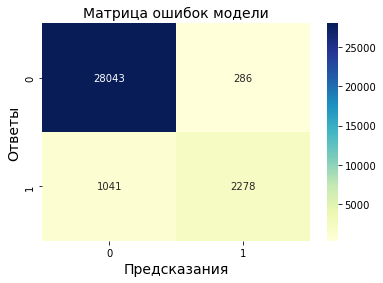

In [38]:
%%time
svc1, f1_svc1 = rndm_pipe_with_test(LinearSVC(random_state=5), 
                                  params=svc_params, 
                                  tfidf=count_tf_idf)

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, max_df=0.7, max_features=15000,
                                 min_df=5, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model', LinearSVC(C=0.5, max_iter=3000, random_state=5))])

F1 на тренировочной выборке 0.775

F1 на

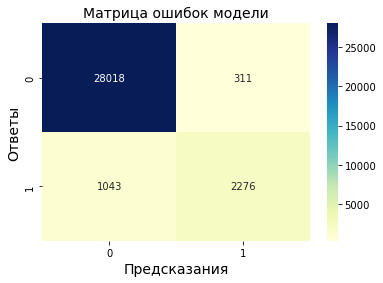

In [39]:
%%time
svc2, f1_svc2 = rndm_pipe_with_test(model=LinearSVC(random_state=5), 
                                  params=svc_params, 
                                  tfidf=count_ngram)

**LGBMClassifier**

In [40]:
params_lgbm = {'model__boosting_type': ['gbdt', 'dart'], 
               'model__num_leaves': [31, 35, 40], 
               'model__n_estimators': [100, 50, 150], 
               'model__class_weight': ['balanced', None]}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.7, max_features=15000, min_df=5,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model', LGBMClassifier(num_leaves=35, random_state=5))])

F1 на тренировочной выборке 0.760

F1 на тестовой выборке 0.750
Wall time: 19min 19s


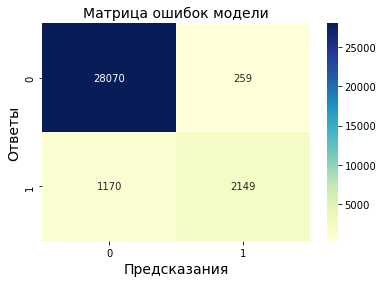

In [41]:
%%time
lbgm1, f1_lbgm1 = rndm_pipe_with_test(model=lgb.LGBMClassifier(n_jobs=-1, random_state=5), 
                                  params=params_lgbm, 
                                  tfidf=count_tf_idf)

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(binary=True, max_df=0.7, max_features=15000,
                                 min_df=5, ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 strip_accents='unicode')),
                ('model', LGBMClassifier(num_leaves=35, random_state=5))])

F1 на тренировочной выборке 0.761

F1 на т

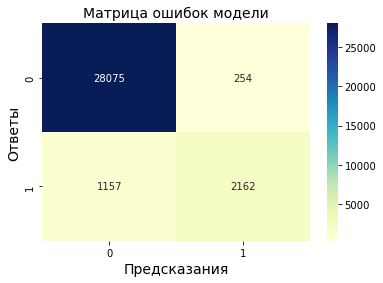

In [42]:
%%time
lbgm2, f1_lbgm2 = rndm_pipe_with_test(model=lgb.LGBMClassifier(n_jobs=-1, random_state=5), 
                                  params=params_lgbm, 
                                  tfidf=count_ngram)

**Вывод**
***  

Модели LogisticRegression, LinearSVC, LGBMClassifier обучены и протестированы на всех выборках.  

Лучшую точность предсказания показала модель LinearSVC(C=0.5, max_iter=3000, random_state=5) на выборке без нграмм, f1 составила на тестовой выборке - 0.774, количество истинно-положительных ответов 2278 из всего 3319, так же, у модели значительно ниже, по сравнению с логистической регрессией количество ложноположительных ответов. f1 модели LinearSVC на выборке с нграммами составила на тестовой выборке 0.771. 

У модели LogisticRegression высокое количество ложноположительных предсказаний - около 1500, в сравнении с моделью LinearSVC - 286.
  
Точность на выборке с нграммами чуть ниже, точности для моделей LinearSVC, LogisticRegression обученных из единичных слов. LGBMClassifier, обученная на словаре нграмм показала точность выше, чем без нграмм: f1 составила 0,754 и 0,750 соответственно. 

## Выводы

In [43]:
results = pd.DataFrame({'f1_train':score, 'f1_test': score_test}, index=model_name).sort_values(by='f1_test',
                                                                                               ascending=False)
results

,f1_train,f1_test
LinearSVC,0.782228,0.774435
LinearSVC_ngramm,0.775191,0.770742
LGBMClassifier_ngramm,0.760692,0.753967
LGBMClassifier,0.760090,0.750480
LogisticRegression,0.743055,0.745926
LogisticRegression_ngramm,0.735076,0.736052


Как на тренировочной, так и на тестовой выборке лучший результат точности показала модель LinearSVC(C=0.5, max_iter=3000, random_state=5), обученная на данных, полученных из единичных слов.  
Худшая точность предсказаний у модели LogisticRegression f1 на тестовой выборке 0,73.

In [44]:
feature_to_coef = { word: coef for word, coef in zip(svc1[0].get_feature_names(), svc1[1].coef_[0]) }

negative, positive = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    negative.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    positive.append(best_positive[0])

Представим наглядно позитивные и негативные слова в текстах датасета для лучшей по точности модели LinearSVC.

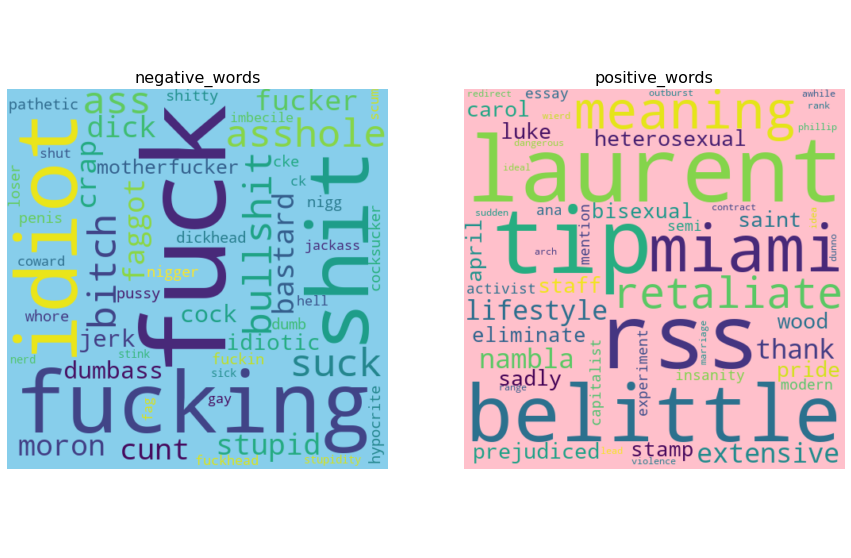

In [45]:
wordplot(negative, positive)

**Вывод**
***
Исходный датасет состоял из двух столбцов - текста комментария и оценки токсичности комментария.  
В датасете обноружено 1310 дубликатов: все они были удалены.  
Тексты комментариев на английском языке. Была проведена предобарботка текстов: оставлены только буквенные символы, проведена лемматизация с помощью spacy.  
Данные не сбалансированы: количество токсичных комментариев в датасете ниже почти в 9 раз.  
Для обучения модели целевой признак - toxic, модель должна определить плохой комментарий.  

Датасет был разделен на тренировоные 80% и тестовые данные 20%. С помощью TfidfVectorizer тексты были преобразованы в матрицу признаков - один датасет с использованием слов, другой - с использованием нграмм.  

Были обучены следующие модели:
- LogisticRegression
- LinearSVC
- LGBMClassifier  

Лучшей по точности прдесказния оказалась модель LinearSVC(C=0.5, max_iter=3000, random_state=5), обученная на датасете из единичных слов, f1 на тестовой выборке составила - 0,774.  
Другие модели показали слудующую точность:  

- LogisticRegression(C=3, class_weight='balanced', max_iter=3000, n_jobs=-1, random_state=5) - f1 составила 0.746;  
- LGBMClassifier(num_leaves=35, random_state=5) - f1 составила 0.754. Для LGBMClassifier лучшей оказалась модель, обученная на словре нграмм.

Удалось получить точность предсказания f1 на моделях LinearSVC, LGBMClassifier. Точность LogisticRegression оказалась ниже - 0746.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x] Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны